In [5]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertModel
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune
import datasets
import transformers
import numpy as np
import os
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertConfig, AdamW, AutoTokenizer, get_scheduler
import datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertConfig, BertModel
import random
import pandas as pd
from IPython.display import display, HTML


<h1>Updates - 7th June 2024 with new DataLoaders provided by Diya</h1>

<h1><strong>QQP TASK</strong></h1>

/home/jovyan/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jovyan/.local/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Batch count: 0
Batch count: 1
Batch count: 2
Batch count: 3
Batch count: 4
Batch count: 5
Batch count: 6
Batch count: 7
Batch count: 8
Batch count: 9
Batch count: 10
Batch count: 11
Batch count: 12
Batch count: 13
Batch count: 14
Batch count: 15
Batch count: 16
Batch count: 17
Batch count: 18
Batch count: 19
Batch count: 20
Batch count: 21
Batch count: 22
Batch count: 23
Batch count: 24
Batch count: 25
Batch count: 26
Batch count: 27
Batch count: 28
Batch count: 29
Batch count: 30
Batch count: 31
Batch count: 32
Batch count: 33
Batch count: 34
Batch count: 35
Batch count: 36
Batch count: 37
Batch count: 38
Batch count: 39
Batch count: 40
Batch count: 41
Batch count: 42
Batch count: 43
Batch count: 44
Batch count: 45
Batch count: 46
Batch count: 47
Batch count: 48
Batch count: 49
Batch count: 50
Batch count: 51
Batch count: 52
Batch count: 53
Batch count: 54
Batch count: 55
Batch count: 56
Batch count: 57
Batch count: 58
Batch count: 59
Batch count: 60
Batch count: 61
Batch count: 62
Ba

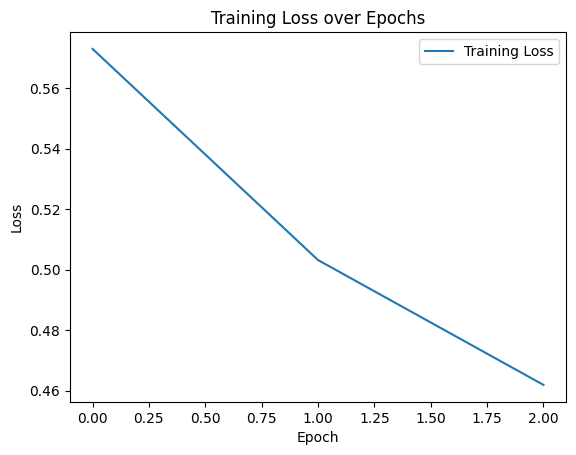

In [24]:
import torch
import datasets
from transformers import BertModel, BertConfig, BertTokenizer, AdamW
from transformers import BertConfig, AdamW, AutoTokenizer, get_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

# Define task and checkpoint
task = "qqp"
checkpoint = "bert-base-uncased"
batch_size = 16


def preprocess_function(examples):
    return tokenizer(examples["question1"], examples["question2"], padding="max_length", truncation=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = datasets.load_dataset("glue", task)
metric = datasets.load_metric("glue", task, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

encoded_dataset['train'] = encoded_dataset['train'].select(range(67349))
QQP_train_dataset = encoded_dataset['train']
QQP_validation_dataset = encoded_dataset['validation']
QQP_train_dataloader = DataLoader(QQP_train_dataset, shuffle=True, batch_size=batch_size)
QQP_validation_dataloader = DataLoader(QQP_validation_dataset, batch_size=batch_size)

# Define model
class BertCustomHead(nn.Module):
    def __init__(self, config, num_classes, task_type='sequence_classification'):
        super(BertCustomHead, self).__init__()
        self.bert = BertModel(config)
        self.task_type = task_type

        self.heads = nn.ModuleDict({
            'sequence_classification': nn.Linear(config.hidden_size, num_classes),
            'token_classification': nn.Linear(config.hidden_size, num_classes),
            'multiple_choice': nn.Linear(config.hidden_size, 1),
            'summarization': nn.Linear(config.hidden_size, config.vocab_size)
        })

        self.loss_fns = {
            'sequence_classification': nn.CrossEntropyLoss(),
            'token_classification': nn.CrossEntropyLoss(),
            'multiple_choice': nn.BCEWithLogitsLoss(),
            'summarization': nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
        }

        if task_type not in self.heads:
            raise ValueError("Invalid task type. Supported types: 'sequence_classification', 'token_classification', 'multiple_choice', 'summarization'")

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, decoder_input_ids=None):
        if self.task_type == 'summarization':
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = outputs.last_hidden_state
            logits = self.heads['summarization'](sequence_output)
            return logits
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            return self.heads[self.task_type](pooled_output)

# Initialize model
config = BertConfig.from_pretrained(checkpoint)
num_classes = 2 
model = BertCustomHead(config, num_classes, task_type='sequence_classification').to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train(model, train_dataloader, val_dataloader, optimizer, num_epochs, device):
    losses = []  # List to store losses for plotting
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_count=0
        for  batch in train_dataloader:
            print(f"Batch count: {batch_count}")
            batch_count+=1
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = model.loss_fns['sequence_classification'](outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Accumulate loss for this batch

        losses.append(epoch_loss / len(train_dataloader))  # Calculate average loss for the epoch
        print(f'Epoch {epoch + 1} completed, Average Loss: {epoch_loss / len(train_dataloader)}')

    return losses

# Training
losses=train(model, QQP_train_dataloader, QQP_validation_dataloader, optimizer, num_epochs=3, device=device)
# Plotting losses
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.savefig('training_loss.png')


In [25]:
import json

save_directory = "/home/jovyan/pub/bert_finetuned_qqp"
os.makedirs(save_directory, exist_ok=True)


base_model_to_save = model.base_model if hasattr(model, 'base_model') else model
if hasattr(base_model_to_save, 'save_pretrained'):
    base_model_to_save.save_pretrained(save_directory)
else:
    torch.save(base_model_to_save.state_dict(), os.path.join(save_directory, 'pytorch_model.bin'))

tokenizer.save_pretrained(save_directory)

model_config_dict = model.bert.config.to_dict()

model_config_dict.update({
    "architectures": ["BertCustomHead"],
    "num_labels": 2,  
    "task_specific_params": {
        "sequence_classification": {
            "num_classes": 2  
        },
        "token_classification": {
            "num_classes": 2  
        },
        "multiple_choice": {
            "num_classes": 4  
        },
        "summarization": {
            "vocab_size": model_config_dict["vocab_size"]  
        }
    }
})

save_directory = "/home/jovyan/pub/bert_finetuned_qqp"


os.makedirs(save_directory, exist_ok=True)


config_path = os.path.join(save_directory, 'config.json')


with open(config_path, 'w') as f:
    json.dump(model_config_dict, f, indent=2)

print(f"Configuration saved to {config_path}")

Configuration saved to /home/jovyan/pub/bert_finetuned_qqp/config.json


<h1><strong>SST2 TASK</strong></h1>

/home/jovyan/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jovyan/.local/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Batch count: 0
Batch count: 1
Batch count: 2
Batch count: 3
Batch count: 4
Batch count: 5
Batch count: 6
Batch count: 7
Batch count: 8
Batch count: 9
Batch count: 10
Batch count: 11
Batch count: 12
Batch count: 13
Batch count: 14
Batch count: 15
Batch count: 16
Batch count: 17
Batch count: 18
Batch count: 19
Batch count: 20
Batch count: 21
Batch count: 22
Batch count: 23
Batch count: 24
Batch count: 25
Batch count: 26
Batch count: 27
Batch count: 28
Batch count: 29
Batch count: 30
Batch count: 31
Batch count: 32
Batch count: 33
Batch count: 34
Batch count: 35
Batch count: 36
Batch count: 37
Batch count: 38
Batch count: 39
Batch count: 40
Batch count: 41
Batch count: 42
Batch count: 43
Batch count: 44
Batch count: 45
Batch count: 46
Batch count: 47
Batch count: 48
Batch count: 49
Batch count: 50
Batch count: 51
Batch count: 52
Batch count: 53
Batch count: 54
Batch count: 55
Batch count: 56
Batch count: 57
Batch count: 58
Batch count: 59
Batch count: 60
Batch count: 61
Batch count: 62
Ba

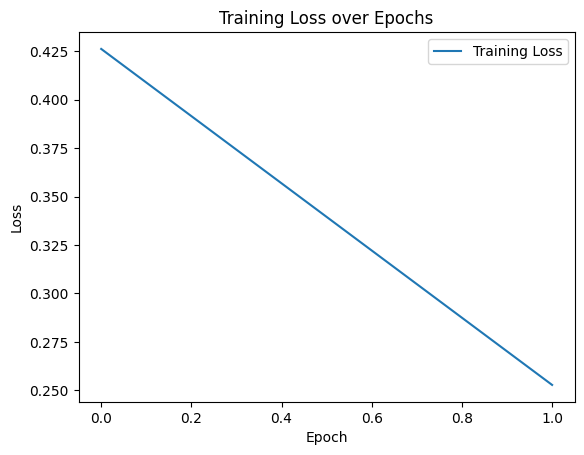

In [16]:
import torch
import datasets
from transformers import BertModel, BertConfig, BertTokenizer, AdamW
from torch.utils.data import DataLoader
import torch.nn as nn

# Define task and checkpoint
task = "sst2"
checkpoint = "bert-base-uncased"
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset and tokenizer
dataset = datasets.load_dataset("glue", task)
metric = datasets.load_metric("glue", task, trust_remote_code=True)  # Use evaluate library in future
tokenizer = BertTokenizer.from_pretrained(checkpoint)

# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True)

# Tokenize the dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Prepare DataLoader
SST_train_dataset = encoded_dataset['train']
SST_validation_dataset = encoded_dataset['validation']
SST_train_dataloader = DataLoader(SST_train_dataset, shuffle=True, batch_size=batch_size)
SST_validation_dataloader = DataLoader(SST_validation_dataset, batch_size=batch_size)

# Define model
class BertCustomHead(nn.Module):
    def __init__(self, config, num_classes, task_type='sequence_classification'):
        super(BertCustomHead, self).__init__()
        self.bert = BertModel(config)
        self.task_type = task_type

        self.heads = nn.ModuleDict({
            'sequence_classification': nn.Linear(config.hidden_size, num_classes),
            'token_classification': nn.Linear(config.hidden_size, num_classes),
            'multiple_choice': nn.Linear(config.hidden_size, 1),
            'summarization': nn.Linear(config.hidden_size, config.vocab_size)
        })

        self.loss_fns = {
            'sequence_classification': nn.CrossEntropyLoss(),
            'token_classification': nn.CrossEntropyLoss(),
            'multiple_choice': nn.BCEWithLogitsLoss(),
            'summarization': nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
        }

        if task_type not in self.heads:
            raise ValueError("Invalid task type. Supported types: 'sequence_classification', 'token_classification', 'multiple_choice', 'summarization'")

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, decoder_input_ids=None):
        if self.task_type == 'summarization':
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = outputs.last_hidden_state
            logits = self.heads['summarization'](sequence_output)
            return logits
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            return self.heads[self.task_type](pooled_output)

# Initialize model
config = BertConfig.from_pretrained(checkpoint)
num_classes = 2  # SST-2 has binary labels: positive and negative
model = BertCustomHead(config, num_classes, task_type='sequence_classification').to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train(model, train_dataloader, val_dataloader, optimizer, num_epochs, device):
    losses = []  # List to store losses for plotting
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_count=0
        for  batch in train_dataloader:
            print(f"Batch count: {batch_count}")
            batch_count+=1
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = model.loss_fns['sequence_classification'](outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Accumulate loss for this batch

        losses.append(epoch_loss / len(train_dataloader))  # Calculate average loss for the epoch
        print(f'Epoch {epoch + 1} completed, Average Loss: {epoch_loss / len(train_dataloader)}')

    return losses

# Training
losses = train(model, SST_train_dataloader, SST_validation_dataloader, optimizer, num_epochs=2, device=device)

# Plotting losses
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [24]:
save_directory = "/home/jovyan/pub/bert_finetuned_sst2"
os.makedirs(save_directory, exist_ok=True)

# Check if the model is wrapped in a DataParallel or DistributedDataParallel
base_model_to_save = model.base_model if hasattr(model, 'base_model') else model
if hasattr(base_model_to_save, 'save_pretrained'):
    base_model_to_save.save_pretrained(save_directory)
else:
    # Handle the saving for custom models
    torch.save(base_model_to_save.state_dict(), os.path.join(save_directory, 'pytorch_model.bin'))

tokenizer.save_pretrained(save_directory)

('/home/jovyan/pub/bert_finetuned_sst2/tokenizer_config.json',
 '/home/jovyan/pub/bert_finetuned_sst2/special_tokens_map.json',
 '/home/jovyan/pub/bert_finetuned_sst2/vocab.txt',
 '/home/jovyan/pub/bert_finetuned_sst2/added_tokens.json')

In [30]:
model_config_dict = model.bert.config.to_dict()


In [32]:
model_config_dict.update({
    "architectures": ["BertCustomHead"],
    "num_labels": 2,  
    "task_specific_params": {
        "sequence_classification": {
            "num_classes": 2  
        },
        "token_classification": {
            "num_classes": 2  
        },
        "multiple_choice": {
            "num_classes": 1  
        },
        "summarization": {
            "vocab_size": model_config_dict["vocab_size"]  
        }
    }
})

In [34]:
import json

save_directory = "/home/jovyan/pub/bert_finetuned_sst2"

# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

# Path to config.json
config_path = os.path.join(save_directory, 'config.json')

# Write the configuration to config.json
with open(config_path, 'w') as f:
    json.dump(model_config_dict, f, indent=2)

print(f"Configuration saved to {config_path}")


Configuration saved to /home/jovyan/pub/bert_finetuned_sst2/config.json
